# 01.4 Cox–Ross–Rubinstein Model  

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Define the Cox–Ross–Rubinstein (CRR) binomial model over $N$ steps.  
- Derive the **no-arbitrage condition** and the **risk-neutral probability** $p^*$.  
- Obtain the **closed-form CRR formula** for a European call option.  
- Check consistency with the tree-based backward induction from 01.3.  
- Illustrate numerically how CRR prices **converge to the Black–Scholes price** as $N \to \infty$.

**The notebook:**

Starts by formalising the CRR dynamics and risk-neutral measure, then implements both the closed-form and tree-based pricing in Python.  
Finally, it compares CRR prices for increasing $N$ to the continuous-time Black–Scholes formula to show how the discrete model approximates the continuous one.


# 1. The Cox–Ross–Rubinstein Binomial Model  

We consider a finite time horizon $T > 0$ and a discrete-time grid with $N$ steps:

$$
0 = t_0 < t_1 < \dots < t_N = T, \quad \Delta t = \frac{T}{N}.
$$

The riskless asset evolves as:
$$
S_n^0 = R^n, \quad R = e^{r \Delta t},
$$
where $r$ is the (continuous) risk-free rate.

The risky asset follows a **multiplicative binomial model**:
$$
S_{n+1}^1 = S_n^1 \times
\begin{cases}
u & \text{with prob. } p,\\
d & \text{with prob. } 1-p,
\end{cases}
$$
with
$$
u = e^{\sigma \sqrt{\Delta t}}, \quad d = e^{-\sigma \sqrt{\Delta t}} = \frac{1}{u}.
$$

Here:
- $\sigma$ is the volatility,
- $u$ and $d$ are chosen so that the variance matches that of a geometric Brownian motion.


## No-arbitrage condition and risk-neutral probability

The **no-arbitrage condition** in the CRR model is:
$$
d < R < u.
$$

Under this condition, there exists a unique **risk-neutral probability** $p^*$ such that the discounted price is a martingale:

$$
\tilde S_n = \frac{S_n^1}{S_n^0}, \quad
E^{\mathbb{P}^*}[\tilde S_{n+1} \mid \mathcal{F}_n] = \tilde S_n.
$$

Solving this gives:
$$
p^* = \frac{R - d}{u - d}, \quad 1 - p^* = \frac{u - R}{u - d}.
$$

# 2. Closed-form CRR formula for a European call

We consider a European call option with:
- initial stock price $S_0$,
- strike $K$,
- maturity $T$,
- $N$ time steps.

At maturity, after $k$ up-moves and $N-k$ down-moves, the stock price is:
$$
S_N^{(k)} = S_0 u^k d^{N-k}.
$$

The payoff is:
$$
h^{(k)} = \max(S_N^{(k)} - K, 0).
$$

Under the risk-neutral measure $\mathbb{P}^*$, the call price at time 0 is:
$$
C_0^{\text{CRR}} =
\frac{1}{R^N}
\sum_{k=0}^N
\binom{N}{k} (p^*)^k (1-p^*)^{N-k} \max(S_0 u^k d^{N-k} - K, 0).
$$

This is the **closed-form CRR formula**.


# 3. Numerical Python implementation (closed form vs tree)

In [2]:
import numpy as np
import pandas as pd
from math import exp, sqrt, log, comb
import matplotlib.pyplot as plt

# Model parameters
S0 = 100.0
K = 100.0
r = 0.05        # continuous risk-free rate
sigma = 0.2     # volatility
T = 1.0         # maturity (in years)

CRR closed-form call price

In [3]:
def crr_call_closed(S0, K, r, sigma, T, N):
    dt = T / N
    R = exp(r * dt)
    u = exp(sigma * sqrt(dt))
    d = 1 / u

    # no-arbitrage check
    if not (d < R < u):
        raise ValueError("No-arbitrage condition d < R < u is violated.")

    p_star = (R - d) / (u - d)

    # stock prices at maturity
    prices = np.array([S0 * (u**k) * (d**(N - k)) for k in range(N + 1)])
    payoffs = np.maximum(prices - K, 0.0)

    # binomial probabilities
    probs = np.array([comb(N, k) * (p_star**k) * ((1 - p_star)**(N - k))
                      for k in range(N + 1)])

    C0 = exp(-r * T) * np.sum(probs * payoffs)
    return C0

Tree-based backward induction (consistency check)

In [4]:
def crr_call_tree(S0, K, r, sigma, T, N):
    dt = T / N
    R = exp(r * dt)
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    p_star = (R - d) / (u - d)

    # stock prices at maturity
    S_N = np.array([S0 * (u**k) * (d**(N - k)) for k in range(N + 1)])
    C = np.maximum(S_N - K, 0.0)

    # backward induction
    for n in range(N - 1, -1, -1):
        C = (p_star * C[1:n+2] + (1 - p_star) * C[0:n+1]) / R
    return C[0]

Compare both methods for a given N

In [ ]:
N_example = 3
C0_closed = crr_call_closed(S0, K, r, sigma, T, N_example)
C0_tree = crr_call_tree(S0, K, r, sigma, T, N_example)
C0_closed, C0_tree

(np.float64(11.04387109195111), np.float64(11.043871091951113))

**Output :** They are almost identicals which indicates a great consistency

# 4. Black–Scholes price for comparison

In [6]:
from math import erf

def norm_cdf(x):
    # Standard normal CDF via error function
    return 0.5 * (1 + erf(x / sqrt(2.0)))

def bs_call_price(S0, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return max(S0 - K * exp(-r * T), 0.0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0 * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)

C0_BS = bs_call_price(S0, K, r, sigma, T)
C0_BS


10.450583572185565

# 5. Convergence of CRR prices to Black–Scholes

In [8]:
N_values = [1, 2, 3, 5, 10, 20, 50, 100, 200]
crr_prices = [crr_call_closed(S0, K, r, sigma, T, N) for N in N_values]
errors = [abs(c - C0_BS) for c in crr_prices]

crr_prices, errors

([np.float64(12.162284964623943),
  np.float64(9.540501338582947),
  np.float64(11.04387109195111),
  np.float64(10.805933920410078),
  np.float64(10.253409044871931),
  np.float64(10.351260189053296),
  np.float64(10.410691540732632),
  np.float64(10.430611662249095),
  np.float64(10.440591259859866)],
 [np.float64(1.7117013924383784),
  np.float64(0.9100822336026173),
  np.float64(0.5932875197655445),
  np.float64(0.3553503482245137),
  np.float64(0.19717452731363316),
  np.float64(0.09932338313226907),
  np.float64(0.03989203145293274),
  np.float64(0.019971909936469245),
  np.float64(0.009992312325698194)])

Plot: CRR price vs N and Black–Scholes benchmark

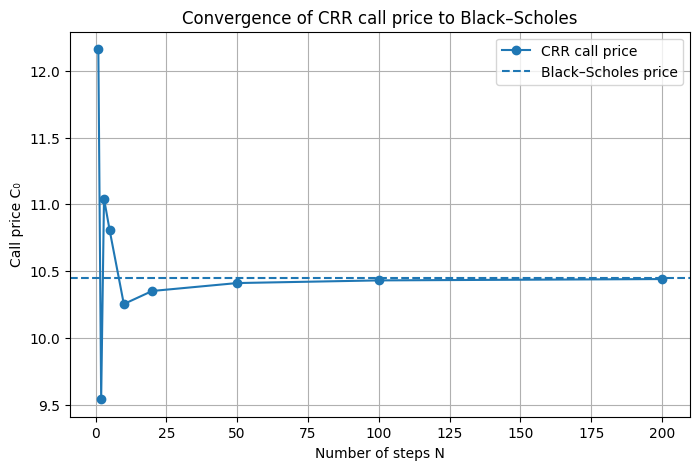

In [9]:
plt.figure(figsize=(8,5))
plt.plot(N_values, crr_prices, marker='o', label="CRR call price")
plt.axhline(C0_BS, linestyle='--', label="Black–Scholes price")
plt.title("Convergence of CRR call price to Black–Scholes")
plt.xlabel("Number of steps N")
plt.ylabel("Call price C₀")
plt.grid(True)
plt.legend()
plt.show()

Plot: absolute error |CRR − BS| vs N

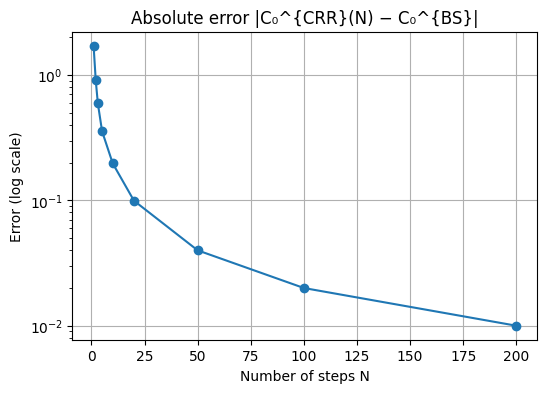

In [11]:
plt.figure(figsize=(6,4))
plt.plot(N_values, errors, marker='o')
plt.yscale("log")
plt.title("Absolute error |C₀^{CRR}(N) − C₀^{BS}|")
plt.xlabel("Number of steps N")
plt.ylabel("Error (log scale)")
plt.grid(True)
plt.show()

# Notes on outputs

**Convergence of CRR call price**

- The CRR call price $C_0^{\text{CRR}}(N)$ quickly stabilizes as $N$ increases.  
- For small $N$ (e.g. $N=1$ or $2$), the discrete structure creates small oscillations around the continuous benchmark.  
- From $N \ge 20$, the price converges smoothly toward the Black–Scholes value $C_0^{BS} \approx 10.45$.  
- For $N=200$, we obtain $C_0^{CRR} \approx 10.44$, a very close match (confirming the **accuracy of the CRR model** as $\Delta t \to 0$).

**Error plot (log scale)**

- The absolute error $|C_0^{CRR} - C_0^{BS}|$ decreases exponentially as $N$ grows.  
- On the log scale, the near-linear decay indicates a **fast convergence rate**, consistent with the Central Limit Theorem.  
- This shows that the binomial model effectively approximates the lognormal distribution used in Black–Scholes.

The outputs confirm that:
> The CRR model is a discrete-time bridge to continuous-time pricing.  
> As the number of steps increases, both price and risk-neutral expectation converge to their continuous Black–Scholes counterparts.
